# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the Pendulum-v1 environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. This Jupyter notebook contains our implementation and report for this project. 

The instructions are available in `Miniproject_DDPG.pdf` file.

## Heuristic policy

In [13]:
import numpy as np
import gym
from helpers import NormalizedEnv
from helpers import RandomAgent

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


In [14]:
# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1')
env = NormalizedEnv(env)

# Create a RandomAgent
random_agent = RandomAgent(env)

# Function that run the agent for a given number of episodes and return the average reward
def run_agent(agent, env, num_episodes):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        while True:
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            if trunc:
                break
        rewards.append(episode_reward)
    return np.mean(rewards)
average_reward = run_agent(random_agent, env, 10)
print('Average reward over 10 episodes: {}'.format(average_reward))

Average reward over 10 episodes: -1322.7127235611256


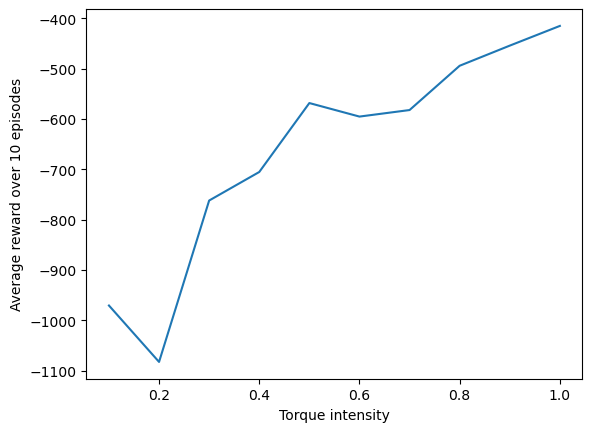

Best torque intensity: 1.0
Best reward over 10 episodes: -415.3524158996791


In [58]:
class HeuristicPendulumAgent:
    def __init__(self, env: NormalizedEnv, torque_intensity: np.float32=np.float32(1.0)) -> None:
        """Heuristic agent for the Pendulum-v1 environment."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state):
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.
        """
        action = np.where(state[..., 0] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., 2]) * self.torque_intensity, 
                        -np.sign(state[..., 2]) * self.torque_intensity).astype(np.float32)
        return action

# Find best torque intensity
torque_intensities = np.linspace(0.1, 1, 10)
rewards = []
for torque_intensity in torque_intensities:
    heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensity)
    rewards.append(run_agent(heuristic_agent, env, 10))

plt.plot(torque_intensities, rewards)
plt.xlabel('Torque intensity')
plt.ylabel('Average reward over 10 episodes')
plt.show()

# Create a HeuristicPendulumAgent with the best torque intensity
heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensities[np.argmax(rewards)])
# Print best reward over 10 episodes and associated torque intensity
print('Best torque intensity: {}'.format(torque_intensities[np.argmax(rewards)]))
print('Best reward over 10 episodes: {}'.format(np.max(rewards)))


## Q function of the heuristic policy

In [112]:
class ReplayBuffer:
    def __init__(self, max_size):
        """Replay buffer used to store a sequence of transitions.

        A transition is a tuple of the form (state, action, reward, next_state, trunc).

        Args:
            max_size (int): Maximum size of the buffer
        """
        self.max_size = max_size
        self.buffer = []

    def store(self, transition):
        """Store a transition in the buffer.

        Args:
            transition (tuple): Transition to store
        """
        self.buffer.append(transition)
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)

    def sample(self, batch_size):
        """Sample a batch of transitions from the buffer.

        Args:
            batch_size (int): Size of the batch to sample

        Returns:
            batch (list): List of transitions
        """
        """# We cast the buffer to a numpy array to facilitate the sampling
        buffer = np.array(self.buffer, dtype=object)
        # Random indices
        indices = np.random.choice(len(buffer), batch_size, replace=False)
        # Sample the batch
        batch = buffer[indices]
        # Delete the sampled transitions from the buffer
        self.buffer = list(np.delete(buffer, indices, axis=0))

        return batch"""

        batch = []
        idxs = np.sort(np.random.choice(len(self.buffer), size=batch_size, replace=False))[::-1]
        for idx in idxs:
            batch.append(self.buffer[idx])
            self.buffer.pop(idx)
        return batch


class QNetwork(nn.Module):
    def __init__(self, state_size=3, action_size=1):
        """QNetwork. Maps (state, action) pairs to Q-values.

        Args:
            state_size (int): Size of the state space
            action_size (int): Size of the action space
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state, action):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        if state.dtype != torch.float32:
            state = state.float()
        if action.dtype != torch.float32:
            action = action.float()
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def TD_learning_update(q_network, agent, optimizer, transitions, gamma):
    """Perform a 1-step TD-learning update for a batch of transitions.

    Args:
        q_network (QNetwork): QNetwork instance
        agent (Agent): Agent (i.e. Policy) instance
        optimizer (torch.optim): Optimizer instance
        transitions (List[Transition]): Batch of transitions
        gamma (float): Discount factor

    Returns:
        loss (float): Loss value
    """
    # Iterate over all the transitions and store each state, action, reward, next_state and trunc in a numpy array
    states = []
    actions = []
    rewards = []
    next_states = []
    truncs = []
    for transition in transitions:
        states.append(transition[0])
        actions.append(transition[1])
        rewards.append(transition[2])
        next_states.append(transition[3])
        truncs.append(transition[4])
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    truncs = np.array(truncs)

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states)
    actions_t = torch.from_numpy(actions)
    rewards_t = torch.from_numpy(rewards)
    next_states_t = torch.from_numpy(next_states)
    truncs_t = torch.from_numpy(truncs)

    with torch.no_grad():
        next_qs = torch.where(
            truncs_t,
            torch.zeros_like(rewards_t),
            q_network(next_states_t, 
                      torch.as_tensor(agent.compute_action(next_states))[:, None]).squeeze())
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t[:, None]).squeeze(), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


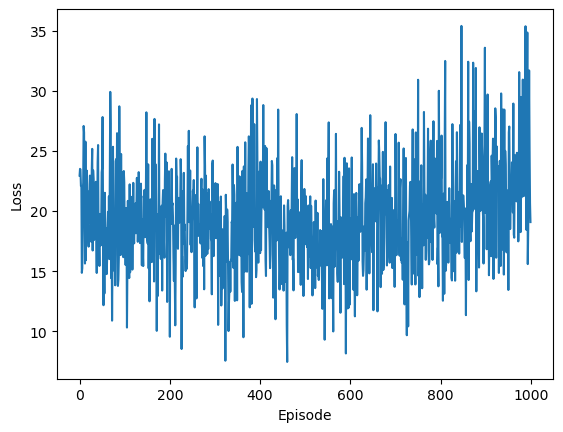

In [113]:
replay_buffer = ReplayBuffer(max_size=10000)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0])
optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
gamma = np.float32(0.99)

losses = []
for episode in range(1000):
    state, _ = env.reset()
    while True:
        action = heuristic_agent.compute_action(state)
        next_state, reward, _, trunc, _ = env.step(action)
        reward = np.float32(reward)
        replay_buffer.store((state, action, reward, next_state, trunc))
        if trunc:
            break
        state = next_state
    transitions = replay_buffer.sample(128)
    loss = TD_learning_update(q_network, heuristic_agent, optimizer, transitions, gamma)
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()


In [98]:
long_losses = losses